# Microbial Diversity Analysis PART3

The following analysis consists of TWO sections:

## 1. Alpha diversity analysis
* Alpha diversity is measured with **Shannnon index** which is calculated in R and have 0.1% ASV removed
## 2. EKSPAE Pathogen abundance analysis
* The relative abundance of potential pathogen in genus ***Staphylococcus*** and ***Pseudomonas*** are calculated in R and analyzed here

____

In [9]:
import numpy as np
from numpy.random import seed
from numpy.random import rand
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sys
from scipy import stats
from scipy.stats import levene
from scipy.stats import bartlett
from scipy.stats import shapiro
from scipy.stats.mstats import kruskal
import scipy.spatial

In [10]:
from scipy.stats import f_oneway
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM
from pingouin import welch_anova, read_dataset
from pingouin import kruskal, read_dataset
from pingouin import ttest
import pingouin as pg

## 1. Alpha diversity analysis
**Import Dataframe**

In [11]:
#Shannon index Calculated in R with ASV <0.1% removed
df = None
updated_shannon=pd.read_csv("/Users/ritalam519/Documents/GitHub/Microbial-analysis/Raw_data/shannon_index.csv",delimiter=",")

In [12]:
updated_shannon.head(5)

,PID,Time,Room_Type,Room_Number,Location,shannon
0,R1T0,T0,Regular,1,AirDuct,3.675357
1,R1T0,T0,Regular,1,Inside_Blind,3.863660
2,R1T0,T0,Regular,1,Outside_Blind,4.554154
3,R1T0,T0,Regular,1,Window,2.414630
4,R1T1,T1,Regular,1,AirDuct,2.948366


* Location: Type of samples collected
* Room_Type: The type of window installed in the patient room, Regular means room with regular window, View mean room with electrochromic (EC) window
* Time: Time that samples were collected: T0 is baseline before patient admission
* shannon: Shannon index which is caulculated for alpha diversity of samples

### Data Processing 

In [13]:
def subgroup(data, field, val):
    return data.loc[data[field] == val]

In [14]:
# Subgrouping based on sample
updated_Window=subgroup(updated_shannon,"Location","Window")
updated_AirSample=subgroup(updated_shannon,"Location","AirSample")
updated_AirDuct=subgroup(updated_shannon,"Location","AirDuct")
updated_Palm=subgroup(updated_shannon,"Location","Palm")
updated_Saliva=subgroup(updated_shannon,"Location","Saliva")
updated_AirSample.head(3)

,PID,Time,Room_Type,Room_Number,Location,shannon
5,R1T1,T1,Regular,1,AirSample,2.244214
16,R1T3,T3,Regular,1,AirSample,2.437575
27,R2T1,T1,Regular,2,AirSample,2.277708


**Window**

In [15]:
updated_Window_RR=subgroup(updated_Window,"Room_Type","Regular")
updated_Window_VR=subgroup(updated_Window,"Room_Type","View")
updated_Window_T0 = subgroup(updated_Window,"Time","T0")
updated_Window_T1 = subgroup(updated_Window,"Time","T1")
updated_Window_T2 = subgroup(updated_Window,"Time","T2")
updated_Window_T3 = subgroup(updated_Window,"Time","T3")
updated_Window_T0.head(3)

,PID,Time,Room_Type,Room_Number,Location,shannon
3,R1T0,T0,Regular,1,Window,2.414630
25,R2T0,T0,Regular,2,Window,3.856632
47,R3T0,T0,Regular,3,Window,2.834841


**Air Duct**

In [16]:
updated_AirDuct_RR=subgroup(updated_AirDuct,"Room_Type","Regular")
updated_AirDuct_VR=subgroup(updated_AirDuct,"Room_Type","View")
updated_AirDuct_T0 = subgroup(updated_AirDuct,"Time","T0")
updated_AirDuct_T1 = subgroup(updated_AirDuct,"Time","T1")
updated_AirDuct_T2 = subgroup(updated_AirDuct,"Time","T2")
updated_AirDuct_T3 = subgroup(updated_AirDuct,"Time","T3")
updated_AirDuct_T0.head(3)

,PID,Time,Room_Type,Room_Number,Location,shannon
0,R1T0,T0,Regular,1,AirDuct,3.675357
22,R2T0,T0,Regular,2,AirDuct,4.369782
44,R3T0,T0,Regular,3,AirDuct,4.364270


**Air Sample**

In [17]:
updated_AirSample_RR=subgroup(updated_AirSample,"Room_Type","Regular")
updated_AirSample_VR=subgroup(updated_AirSample,"Room_Type","View")
updated_AirSample_T1 = subgroup(updated_AirSample,"Time","T1")
updated_AirSample_T3 = subgroup(updated_AirSample,"Time","T3")
updated_AirSample_T1.head(3)

,PID,Time,Room_Type,Room_Number,Location,shannon
5,R1T1,T1,Regular,1,AirSample,2.244214
27,R2T1,T1,Regular,2,AirSample,2.277708
49,R3T1,T1,Regular,3,AirSample,2.713925


**Palm**

In [18]:
updated_Palm_RR=subgroup(updated_Palm,"Room_Type","Regular")
updated_Palm_VR=subgroup(updated_Palm,"Room_Type","View")
updated_Palm_T1 = subgroup(updated_Palm,"Time","T1")
updated_Palm_T3 = subgroup(updated_Palm,"Time","T3")
updated_Palm_T1.head(3)

,PID,Time,Room_Type,Room_Number,Location,shannon
8,R1T1,T1,Regular,1,Palm,4.006666
30,R2T1,T1,Regular,2,Palm,4.010411
52,R3T1,T1,Regular,3,Palm,2.935132


**Saliva**

In [19]:
updated_Saliva_RR=subgroup(updated_Saliva,"Room_Type","Regular")
updated_Saliva_VR=subgroup(updated_Saliva,"Room_Type","View")
updated_Saliva_T1 = subgroup(updated_Saliva,"Time","T1")
updated_Saliva_T3 = subgroup(updated_Saliva,"Time","T3")
updated_Saliva_T3.head(3)

,PID,Time,Room_Type,Room_Number,Location,shannon
20,R1T3,T3,Regular,1,Saliva,3.230730
42,R2T3,T3,Regular,2,Saliva,2.100370
64,R3T3,T3,Regular,3,Saliva,3.114857


### Initial Data visualization

In [20]:
#Set color palette
palette = {"View":"#95d0fc",
           "Regular":"#ffa756"}
palette2= {"View":"white",
           "Regular":"white"}
color1= {"View":"#a2cffe",
           "Regular":"#d8dcd6"}
color2= {"View":"#75bbfd",
           "Regular":"#929591"}

(0.0, 6.0)

<Figure size 1600x1400 with 0 Axes>

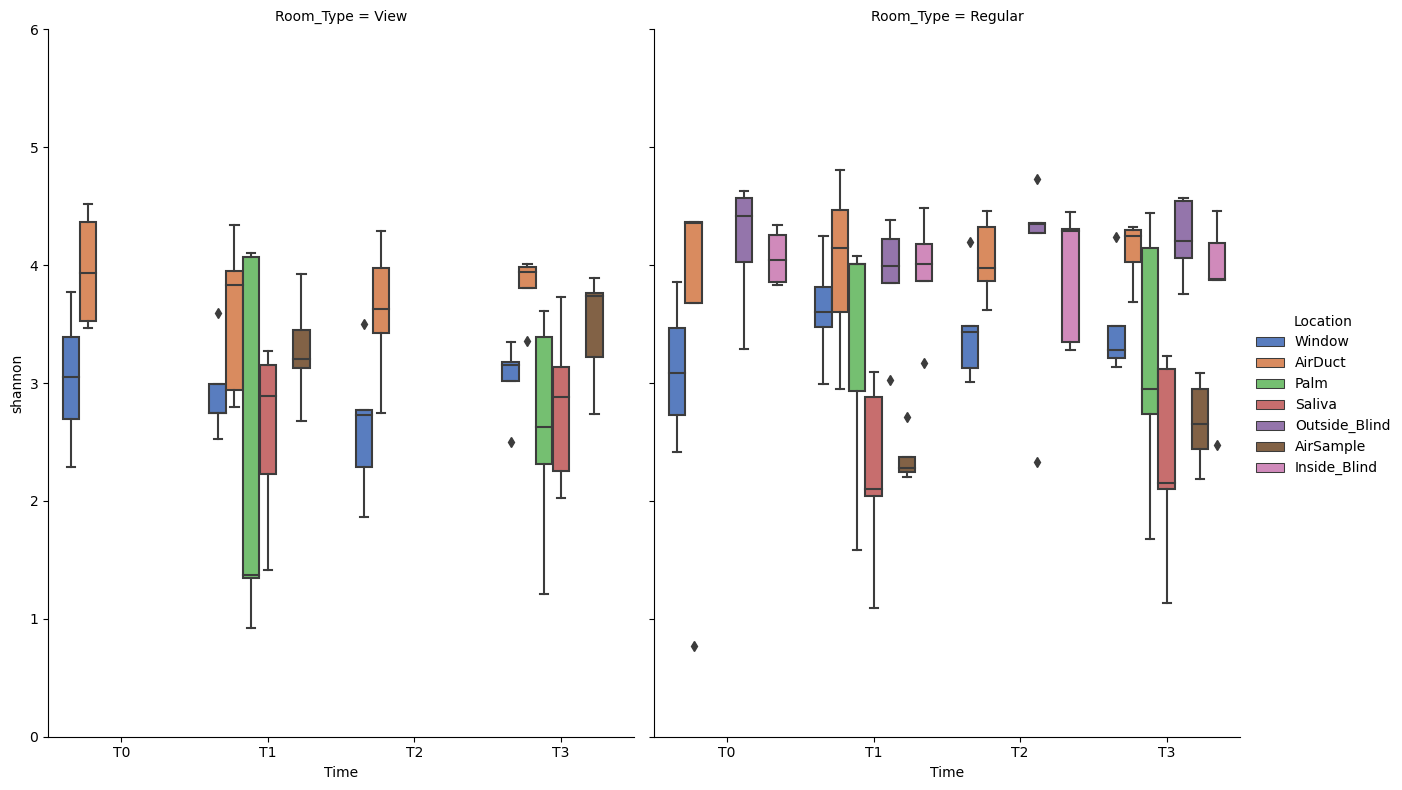

In [21]:
#Overview of shannon diversity calculated from R
plt.figure(figsize= (16,14))
g = sns.catplot(x="Time", y="shannon",
                hue="Location", hue_order=['Window','AirDuct','Palm','Saliva',
                                           'Outside_Blind','AirSample','Inside_Blind'],
                col='Room_Type',order=['T0','T1','T2','T3'],
                col_wrap=2, col_order=['View','Regular'], palette='muted',
                data=updated_shannon, kind="box", dodge=True,
                height=8, aspect=.8);
plt.ylim(0,6)

____
##  Statistical analysis of Alpha diversity

###  Window (Shannon index)

**Inital data visualizaiton**

(0.0, 6.0)

<Figure size 1000x800 with 0 Axes>

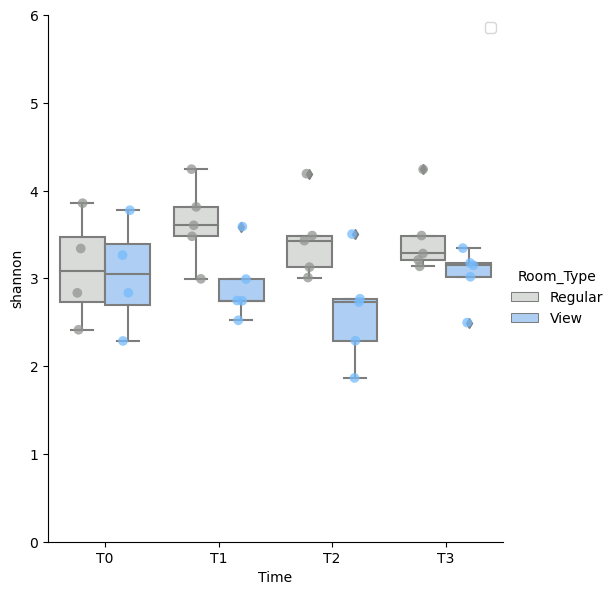

In [22]:
plt.figure(figsize= (10,8))
#Plot qPCR Results Separatly
ax=sns.catplot(x="Time", y="shannon",
            hue="Room_Type", order=['T0','T1','T2','T3'], hue_order=('Regular','View'), 
            kind="box", dodge=True, height=6, aspect=.9,
            palette=color1, data=updated_Window)
ax = sns.stripplot(x='Time', y='shannon', hue='Room_Type',order=['T0','T1','T2','T3'],
                   hue_order=('Regular','View'), palette=color2,
                   jitter=True,size=7, dodge=True, marker='o', alpha=0.75, data=updated_Window)

# how to remove redundant legends in Python
# Let us first get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[1:1], labels[1:1]).set_title('')
ax.set(ylabel="shannon")
plt.ylim(0,6)

#### Normality assessment

In [23]:
stat, p = shapiro(updated_Window['shannon'])
print('Shapiro statistics of Window shannnon iindex=%.3f, p=%.3f' % (stat, p))

Shapiro statistics of Window shannnon iindex=0.986, p=0.899


In [24]:
#Using Pinguin to access normality 
pg.normality(data=updated_Window, dv='shannon', group='Time') 

,W,pval,normal
T0,0.936394,0.575984,True
T1,0.944943,0.609201,True
T2,0.978892,0.958962,True
T3,0.871885,0.105147,True


In [25]:
#Using Pinguin to access normality with Shapiro Wilk test
pg.normality(data=updated_Window, dv='shannon', group='Room_Type') 

,W,pval,normal
Regular,0.963076,0.634259,True
View,0.986428,0.990703,True


**Variance test**

In [26]:
# Levene Test
stat, p =  levene(updated_Window_RR["shannon"], updated_Window_VR["shannon"])
print("P-value of levene test for variance acroos Regular and EC Window room is:", p)
stat, p =  levene(updated_Window_T0["shannon"], updated_Window_T1["shannon"],
                  updated_Window_T2["shannon"], updated_Window_T3["shannon"])
print("P-value of levene test for variance across time is:", p)

P-value of levene test for variance acroos Regular and EC Window room is: 0.8687165517626236
P-value of levene test for variance across time is: 0.3068766327715562


**Shannon diversity of window samples are nmormally distributed and have homogenous variance** 

#### Effect of Indoor daylight (Room_Type variable) on **Window** shannon index at each time

In [27]:
#Subgroup for each Timepoint 
updated_Window_T1_R=subgroup(updated_Window_T1, "Room_Type","Regular")
updated_Window_T1_V=subgroup(updated_Window_T1, "Room_Type","View")
updated_Window_T2_R=subgroup(updated_Window_T2, "Room_Type","Regular")
updated_Window_T2_V=subgroup(updated_Window_T2, "Room_Type","View")
updated_Window_T3_R=subgroup(updated_Window_T3, "Room_Type","Regular")
updated_Window_T3_V=subgroup(updated_Window_T3, "Room_Type","View")
updated_Window_T0_R=subgroup(updated_Window_T0, "Room_Type","Regular")
updated_Window_T0_V=subgroup(updated_Window_T0, "Room_Type","View")
updated_Window_T1_R

,PID,Time,Room_Type,Room_Number,Location,shannon
10,R1T1,T1,Regular,1,Window,2.994318
32,R2T1,T1,Regular,2,Window,3.604434
54,R3T1,T1,Regular,3,Window,3.479172
78,R5T1,T1,Regular,5,Window,4.244032
96,R6T1,T1,Regular,6,Window,3.814508


In [28]:
#Two sample T-test at T0 between Two Room Type
res=ttest(updated_Window_T0_R['shannon'], updated_Window_T0_V['shannon'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.159066,6,two-sided,0.878836,"[-1.02, 1.16]",0.112477,0.527,0.052104


In [29]:
#Two sample T-test at T1 between Two Room Type
res=ttest(updated_Window_T1_R['shannon'], updated_Window_T1_V['shannon'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.576158,8,two-sided,0.032812,"[0.07, 1.34]",1.629306,2.408,0.61849


In [30]:
#Two sample T-test at T2 between Two Room Type
res=ttest(updated_Window_T2_R['shannon'], updated_Window_T2_V['shannon'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.388895,8,two-sided,0.043932,"[0.03, 1.61]",1.51087,2.012,0.555289


In [31]:
#Two sample T-test at T3 between Two Room Type
res=ttest(updated_Window_T3_R['shannon'], updated_Window_T3_V['shannon'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.756198,8,two-sided,0.117123,"[-0.14, 1.01]",1.110717,1.14,0.340294


#### Effect of Occupancy (Time variable) on **Window** shannon index in each rom type

In [32]:
# One-Ways Repeated ANOVA on AirSample in regular room
aov = pg.rm_anova(dv='shannon', within=['Time'], subject='Room_Number', data=updated_Window_RR)
print(aov)

  Source  ddof1  ddof2         F     p-unc       np2       eps
0   Time      3      6  0.832228  0.523069  0.293842  0.346123


In [33]:
# One-Ways Repeated ANOVA on AirSample in EC window Room
aov = pg.rm_anova(dv='shannon', within=['Time'], subject='Room_Number', data=updated_Window_VR)
print(aov)

  Source  ddof1  ddof2        F     p-unc       np2       eps
0   Time      3      9  0.28114  0.837786  0.085684  0.565585



## Air Sample (Shannon index)
**Initial data visualization**

(0.0, 6.0)

<Figure size 1000x800 with 0 Axes>

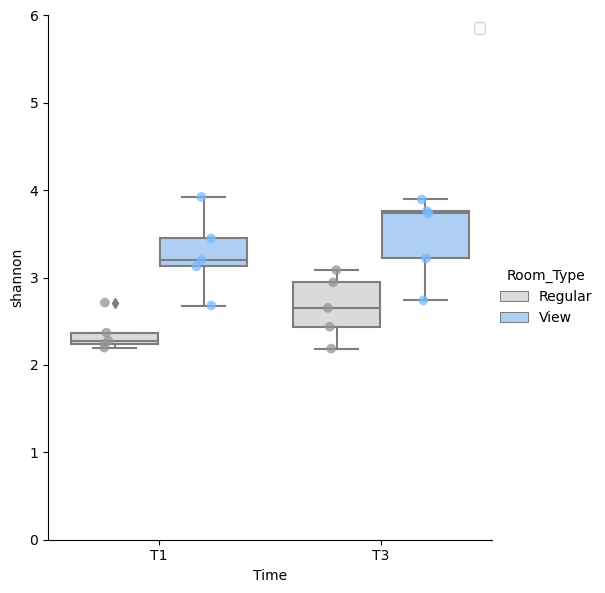

In [34]:
#AirSample
plt.figure(figsize= (10,8))
#Plot qPCR Results Separatly
ax=sns.catplot(x="Time", y="shannon",
            hue="Room_Type", order=['T1','T3'], hue_order=('Regular','View'), 
            kind="box", dodge=True, height=6, aspect=.9,
            palette=color1, data=updated_AirSample)
ax = sns.stripplot(x='Time', y='shannon', hue='Room_Type',order=['T1','T3'],
                   hue_order=('Regular','View'), palette=color2,
                   jitter=True,size=7, dodge=True, marker='o', alpha=0.75, data=updated_AirSample)

# how to remove redundant legends in Python
# Let us first get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[1:1], labels[1:1]).set_title('')
ax.set(ylabel="shannon")
plt.ylim(0,6)

#### Noirmality test

In [35]:
stat, p = shapiro(updated_AirSample['shannon'])
print('Shapiro statistics of AirSample shannnon iindex=%.3f, p=%.3f' % (stat, p))

Shapiro statistics of AirSample shannnon iindex=0.924, p=0.118


In [36]:
# Normality of Window Dataframe for each Timepoints
pg.normality(data=updated_AirSample, dv='shannon', group='Room_Type')

,W,pval,normal
Regular,0.887742,0.159909,True
View,0.915201,0.318663,True


In [37]:
# Normality of Window Dataframe for each Timepoints
pg.normality(data=updated_Window, dv='shannon', group='Time')

,W,pval,normal
T0,0.936394,0.575984,True
T1,0.944943,0.609201,True
T2,0.978892,0.958962,True
T3,0.871885,0.105147,True


**Variance Test**

In [38]:
# Levene Test
stat, p =  levene(updated_AirSample_RR["shannon"], updated_AirSample_VR["shannon"])
print("P-value of levene test for variance acroos Regular and EC Window room is:", p)
stat, p =  levene(updated_AirSample_T1["shannon"], updated_AirSample_T3["shannon"])
print("P-value of levene test for variance across time is:", p)

P-value of levene test for variance acroos Regular and EC Window room is: 0.21356299965333705
P-value of levene test for variance across time is: 0.9530811070290648


* Air Sample's Shannon index met both normality and variance assumptions


#### Effect of Indoor daylight (Room_Type variable) on **Air Sample** shannon index at each time

In [39]:
#Subgrouping
updated_AirSample_T1_R=subgroup(updated_AirSample_T1, "Room_Type","Regular")
updated_AirSample_T1_V=subgroup(updated_AirSample_T1, "Room_Type","View")
updated_AirSample_T3_R=subgroup(updated_AirSample_T3, "Room_Type","Regular")
updated_AirSample_T3_V=subgroup(updated_AirSample_T3, "Room_Type","View")

In [40]:
# 2 sample T-test At Time 1 between Two Room Type
res=ttest(updated_AirSample_T1_R['shannon'], updated_AirSample_T1_V['shannon'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.087481,8,two-sided,0.003498,"[-1.43, -0.4]",2.58515,10.842,0.945515


In [41]:
# 2 sample T-test At Time 3 between Two Room Type
res=ttest(updated_AirSample_T3_R['shannon'], updated_AirSample_T3_V['shannon'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.981767,8,two-sided,0.017553,"[-1.43, -0.18]",1.885835,3.588,0.742966


#### Effect of Occupancy (Time variable) on **AirSample** shannon index in each rom type

In [42]:
# One-Ways Repeated ANOVA on AirSample in regular room
aov = pg.rm_anova(dv='shannon', within=['Time'], subject='Room_Number', data=updated_AirSample_RR)
print(aov)

  Source  ddof1  ddof2         F     p-unc       np2  eps
0   Time      1      4  3.995933  0.116251  0.499746  1.0


In [43]:
# One-Ways Repeated ANOVA on AirSample in EC Window room
aov = pg.rm_anova(dv='shannon', within=['Time'], subject='Room_Number', data=updated_AirSample_VR)
print(aov)

  Source  ddof1  ddof2         F     p-unc       np2  eps
0   Time      1      4  0.401248  0.560856  0.091167  1.0



## AirDuct (Shannon index)
**Initial data visualization**

(0.0, 6.0)

<Figure size 1000x800 with 0 Axes>

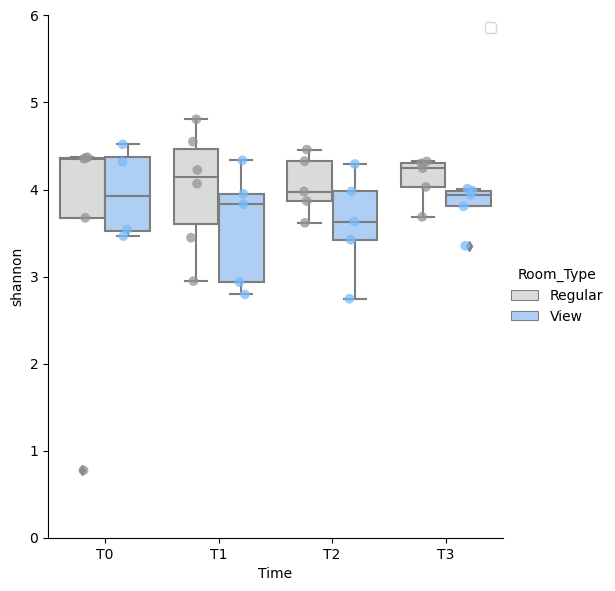

In [44]:
plt.figure(figsize= (10,8))
ax=sns.catplot(x="Time", y="shannon",
            hue="Room_Type", order=['T0','T1','T2','T3'], hue_order=('Regular','View'), 
            kind="box", dodge=True, height=6, aspect=.9,
            palette=color1, data=updated_AirDuct)
ax = sns.stripplot(x='Time', y='shannon', hue='Room_Type',order=['T0','T1','T2','T3'],
                   hue_order=('Regular','View'), palette=color2,
                   jitter=True,size=7, dodge=True, marker='o', alpha=0.75, data=updated_AirDuct)

# how to remove redundant legends in Python
# Let us first get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[1:1], labels[1:1]).set_title('')
ax.set(ylabel="shannon")
plt.ylim(0,6)

#### Normality assessment

In [45]:
stat, p = shapiro(updated_AirDuct['shannon'])
print('Shapiro statistics of AirDuct shannnon iindex=%.3f, p=%.3f' % (stat, p))

Shapiro statistics of AirDuct shannnon iindex=0.809, p=0.000


In [46]:
# Normality of AirDuct Dataframe for each Timepoints
pg.normality(data=updated_AirDuct, dv='shannon', group='Room_Type')

,W,pval,normal
Regular,0.692142,0.000022,False
View,0.941997,0.286381,True


In [47]:
# Normality of AirDuct Dataframe for each Timepoints
pg.normality(data=updated_AirDuct, dv='shannon', group='Time')

,W,pval,normal
T0,0.674424,0.000713,False
T1,0.932485,0.436537,True
T2,0.930973,0.457528,True
T3,0.929463,0.442630,True


**Variance test**

In [48]:
# Levene Test
stat, p =  levene(updated_AirDuct_RR["shannon"], updated_AirDuct_VR["shannon"])
print("P-value of levene test for variance across Regular and EC Window room is:", p)
stat, p =  levene(updated_AirDuct_T0["shannon"], updated_AirDuct_T1["shannon"],
                  updated_AirDuct_T2["shannon"], updated_AirDuct_T3["shannon"])
print("P-value of levene test for variance across time is:", p)

P-value of levene test for variance across Regular and EC Window room is: 0.6891546614618668
P-value of levene test for variance across time is: 0.3597458989385709


* Shannon index of Air Duct are NOT normally distributed overall, (Air duct in regular window room and at baseline)


#### Effect of Indoor daylight (Room_Type variable) on **Air Sample** shannon index at each time

In [49]:
#Subgroup for each Timepoint 
updated_AirDuct_T1_R=subgroup(updated_AirDuct_T1, "Room_Type","Regular")
updated_AirDuct_T1_V=subgroup(updated_AirDuct_T1, "Room_Type","View")
updated_AirDuct_T2_R=subgroup(updated_AirDuct_T2, "Room_Type","Regular")
updated_AirDuct_T2_V=subgroup(updated_AirDuct_T2, "Room_Type","View")
updated_AirDuct_T3_R=subgroup(updated_AirDuct_T3, "Room_Type","Regular")
updated_AirDuct_T3_V=subgroup(updated_AirDuct_T3, "Room_Type","View")
updated_AirDuct_T0_R=subgroup(updated_AirDuct_T0, "Room_Type","Regular")
updated_AirDuct_T0_V=subgroup(updated_AirDuct_T0, "Room_Type","View")
updated_AirDuct_T1_R

,PID,Time,Room_Type,Room_Number,Location,shannon
4,R1T1,T1,Regular,1,AirDuct,2.948366
26,R2T1,T1,Regular,2,AirDuct,4.067485
48,R3T1,T1,Regular,3,AirDuct,4.549596
67,R4T1,T1,Regular,4,AirDuct,4.807048
72,R5T1,T1,Regular,5,AirDuct,3.446957
90,R6T1,T1,Regular,6,AirDuct,4.225236


In [50]:
#AirDuct T0 MannWhitney U test as it is NOT normally diostributed
scipy.stats.mannwhitneyu(updated_AirDuct_T0_R['shannon'], updated_AirDuct_T0_V['shannon'], alternative='two-sided')

MannwhitneyuResult(statistic=11.0, pvalue=0.9047619047619049)

In [51]:
# 2 sample T-test At Time 1 between Two Room Type
res=ttest(updated_AirDuct_T1_R['shannon'], updated_AirDuct_T1_V['shannon'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.059293,8.755866,two-sided,0.317812,"[-0.5, 1.38]",0.63909,0.676,0.157159


In [52]:
# 2 sample T-test At Time 2 between Two Room Type
res=ttest(updated_AirDuct_T2_R['shannon'], updated_AirDuct_T2_V['shannon'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.429615,8,two-sided,0.190694,"[-0.27, 1.14]",0.904168,0.881,0.243172


In [53]:
# 2 sample T-test At Time 3 between Two Room Type
res=ttest(updated_AirDuct_T3_R['shannon'], updated_AirDuct_T3_V['shannon'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.738196,8,two-sided,0.120374,"[-0.1, 0.69]",1.099332,1.123,0.334561


#### Effect of Occupancy (Time variable) on **Air Duct** shannon index in each rom type

In [54]:
#Regular Room is not normally distribtued, friedman test to see the block effect of TIME
res= pg.friedman(data=updated_AirDuct_RR, dv="shannon", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.225,3,2.7,0.440227


In [55]:
# One-Ways Repeated ANOVA on AirSample in EC window room
aov = pg.rm_anova(dv='shannon', within=['Time'], subject='Room_Number', data=updated_AirDuct_VR)
print(aov)

  Source  ddof1  ddof2         F     p-unc       np2       eps
0   Time      3      9  1.240826  0.351018  0.292591  0.549603


**Did not detect differences in any of the Palm sample**

### Saliva (Shannon index)

**Inital data vsiauzalizationt**

(0.0, 6.0)

<Figure size 1000x800 with 0 Axes>

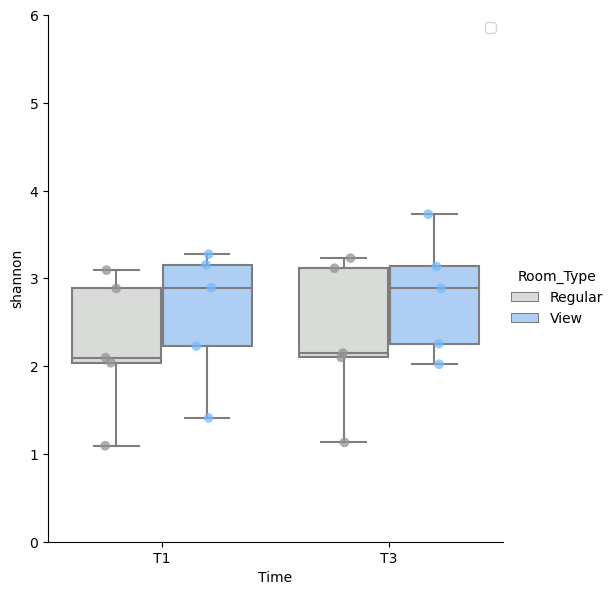

In [56]:
plt.figure(figsize= (10,8))
#Plot qPCR Results Separatly
ax=sns.catplot(x="Time", y="shannon",
            hue="Room_Type", order=['T1','T3'], hue_order=('Regular','View'), 
            kind="box", dodge=True, height=6, aspect=.9,
            palette=color1, data=updated_Saliva)
ax = sns.stripplot(x='Time', y='shannon', hue='Room_Type',order=['T1','T3'],
                   hue_order=('Regular','View'), palette=color2,
                   jitter=True,size=7, dodge=True, marker='o', alpha=0.75, data=updated_Saliva)

# how to remove redundant legends in Python
# Let us first get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[1:1], labels[1:1]).set_title('')
ax.set(ylabel="shannon")
plt.ylim(0,6)

**Normlaity and variance test**

In [57]:
stat, p = shapiro(updated_Saliva['shannon'])
print('Shapiro statistics of Saliva shannnon iindex=%.3f, p=%.3f' % (stat, p))

Shapiro statistics of Saliva shannnon iindex=0.926, p=0.129


In [58]:
# Levene Test
stat, p =  levene(updated_Saliva_RR["shannon"], updated_Saliva_VR["shannon"])
print("P-value of levene test for variance across Regular and EC Window room is:", p)
stat, p =  levene(updated_Saliva_T1["shannon"],
                  updated_Saliva_T3["shannon"])
print("P-value of levene test for variance across time is:", p)

P-value of levene test for variance across Regular and EC Window room is: 0.7706389185493803
P-value of levene test for variance across time is: 0.9966161106371884



#### Effect of Indoor daylight (Room_Type variable) on shannon index of **Saliva** at each time

In [59]:
updated_Saliva_T1_R=subgroup(updated_Saliva_T1, "Room_Type","Regular")
updated_Saliva_T1_V=subgroup(updated_Saliva_T1, "Room_Type","View")
updated_Saliva_T3_R=subgroup(updated_Saliva_T3, "Room_Type","Regular")
updated_Saliva_T3_V=subgroup(updated_Saliva_T3, "Room_Type","View")

In [60]:
# 2 sample T-test At Time 1 between Two Room Type
res=ttest(updated_Saliva_T1_R['shannon'], updated_Saliva_T1_V['shannon'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.707444,8,two-sided,0.499377,"[-1.49, 0.79]",0.447427,0.574,0.096


In [61]:
# 2 sample T-test at Time 3 between Two Room Type
res=ttest(updated_Saliva_T3_R['shannon'], updated_Saliva_T3_V['shannon'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.937354,8,two-sided,0.376008,"[-1.59, 0.67]",0.592835,0.642,0.131694


#### Effect of Occupancy (Time variable) on **Saliva** shannon index in each rom type

In [62]:
# One-Ways Repeated ANOVA on AirSample in EC window room
aov = pg.rm_anova(dv='shannon', within=['Time'], subject='Room_Number', data=updated_Saliva_RR)
print(aov)

  Source  ddof1  ddof2         F    p-unc       np2  eps
0   Time      1      4  8.310145  0.04489  0.675065  1.0


In [63]:
# One-Ways Repeated ANOVA on AirSample in EC window room
aov = pg.rm_anova(dv='shannon', within=['Time'], subject='Room_Number', data=updated_Saliva_VR)
print(aov)

  Source  ddof1  ddof2         F     p-unc       np2  eps
0   Time      1      4  1.034372  0.366647  0.205462  1.0



### Palm Sample (Shannon index)


(0.0, 6.0)

<Figure size 1000x800 with 0 Axes>

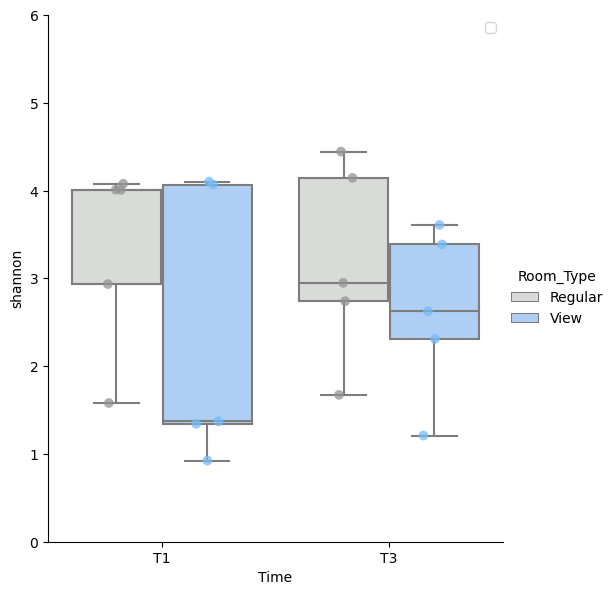

In [64]:
plt.figure(figsize= (10,8))
#Plot qPCR Results Separatly
ax=sns.catplot(x="Time", y="shannon",
            hue="Room_Type", order=['T1','T3'], hue_order=('Regular','View'), 
            kind="box", dodge=True, height=6, aspect=.9,
            palette=color1, data=updated_Palm)
ax = sns.stripplot(x='Time', y='shannon', hue='Room_Type',order=['T1','T3'],
                   hue_order=('Regular','View'), palette=color2,
                   jitter=True,size=7, dodge=True, marker='o', alpha=0.75, data=updated_Palm)

# how to remove redundant legends in Python
# Let us first get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[1:1], labels[1:1]).set_title('')
ax.set(ylabel="shannon")
plt.ylim(0,6)

**Normality and variance test**

In [65]:
stat, p = shapiro(updated_Palm['shannon'])
print('Shapiro statistics of Palm shannnon index=%.3f, p=%.3f' % (stat, p))

Shapiro statistics of Palm shannnon index=0.898, p=0.038


In [66]:
# Normality of AirDuct Dataframe for each Timepoints
pg.normality(data=updated_Palm, dv='shannon', group='Time')

,W,pval,normal
T1,0.779226,0.008101,False
T3,0.979985,0.965088,True


In [67]:
# Normality of AirDuct Dataframe for each Timepoints
pg.normality(data=updated_Palm, dv='shannon', group='Room_Type')

,W,pval,normal
Regular,0.869663,0.099065,True
View,0.889076,0.165556,True


In [68]:
# Levene Test
stat, p =  levene(updated_Palm_RR["shannon"], updated_Palm_VR["shannon"])
print("P-value of levene test for variance across Regular and EC Window room is:", p)
stat, p =  levene(updated_Palm_T1["shannon"],
                  updated_Palm_T3["shannon"])
print("P-value of levene test for variance across time is:", p)

P-value of levene test for variance across Regular and EC Window room is: 0.45178767367121764
P-value of levene test for variance across time is: 0.2187000112386129



#### Effect of Indoor daylight (Room_Type variable) on shannon index of **Palm** at each time

In [69]:
updated_Palm_T1_R=subgroup(updated_Palm_T1, "Room_Type","Regular")
updated_Palm_T1_V=subgroup(updated_Palm_T1, "Room_Type","View")
updated_Palm_T3_R=subgroup(updated_Palm_T3, "Room_Type","Regular")
updated_Palm_T3_V=subgroup(updated_Palm_T3, "Room_Type","View")

In [70]:
#Palm T1 MannWhitney U test
scipy.stats.mannwhitneyu(updated_Palm_T1_R['shannon'], updated_Palm_T1_V['shannon'], alternative='two-sided')

MannwhitneyuResult(statistic=16.0, pvalue=0.5476190476190477)

In [71]:
#Palm Time3 2 sample t-test
res=ttest(updated_Palm_T3_R['shannon'], updated_Palm_T3_V['shannon'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.851978,8,two-sided,0.418999,"[-0.96, 2.08]",0.538838,0.614,0.117204


___
# 2 EKSPAE pathogen's relative abundance analysis

* Relative abundance of genus ***Staphylococcus*** AND ***Pseudomonas*** are calculated in R, and imported here. 

**Import Data**

In [72]:
#Staphylococcus Relative Abundance at the genus level
Staph = pd.read_csv("/Users/ritalam519/Documents/GitHub/Microbial-analysis/Raw_data/Staphylococcus_abundance.csv",delimiter=",", header = 0,index_col=0)
Staph.head(5)

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Phlylum,Class,Order,Family,Genus
Sample,,,,,,,,,,,
R1T0_AD,1,0.265085,AirDuct,Regular,T0,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
R1T0_IB,1,0.529014,Inside-Blind,Regular,T0,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
R1T0_OB,1,0.257763,Outside-Blind,Regular,T0,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
R1T0_W,1,0.504211,Window,Regular,T0,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
R1T1_AD,1,0.265734,AirDuct,Regular,T1,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus


In [73]:
#Staphylococcus Relative Abundance at the genus level
Pseudo = pd.read_csv("/Users/ritalam519/Documents/GitHub/Microbial-analysis/Raw_data/Pseudomonas_abundance.csv",delimiter=",", header = 0,index_col=0)
Pseudo.head(5)

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Genus
Sample,,,,,,,
R1T0_AD,1,0.014183,AirDuct,Regular,T0,Bacteria,Pseudomonas
R1T0_IB,1,0.021184,Inside-Blind,Regular,T0,Bacteria,Pseudomonas
R1T0_OB,1,0.032749,Outside-Blind,Regular,T0,Bacteria,Pseudomonas
R1T0_W,1,0.000000,Window,Regular,T0,Bacteria,Pseudomonas
R1T1_AD,1,0.000000,AirDuct,Regular,T1,Bacteria,Pseudomonas


## Data processing 

**Genus Staphylcooccus**

In [74]:
#subgroup for each sample
Window_Staph=subgroup(Staph,"location","Window")
AirDuct_Staph=subgroup(Staph, "location","AirDuct")
Saliva_Staph=subgroup(Staph,"location","Saliva")
Palm_Staph=subgroup(Staph,"location","Palm")
OB_Staph=subgroup(Staph,"location","Outside-Blind")
IB_Staph=subgroup(Staph,"location","Inside-Blind")
AirSample_Staph=subgroup(Staph,"location","AirFilter")
AirSample_Staph.head(5)

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Phlylum,Class,Order,Family,Genus
Sample,,,,,,,,,,,
R1T1_AF,1,0.000000,AirFilter,Regular,T1,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
R1T3_AF,1,0.000000,AirFilter,Regular,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
R2T1_AF,2,0.000248,AirFilter,Regular,T1,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
R2T3_AF,2,0.166901,AirFilter,Regular,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
R3T1_AF,3,0.086688,AirFilter,Regular,T1,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus


**Genus Pseudomonmas**

In [75]:
#subgroup for each sample
Window_Pseudo=subgroup(Pseudo,"location","Window")
AirDuct_Pseudo=subgroup(Pseudo, "location","AirDuct")
Saliva_Pseudo=subgroup(Pseudo,"location","Saliva")
Palm_Pseudo=subgroup(Pseudo,"location","Palm")
OB_Pseudo=subgroup(Pseudo,"location","Outside-Blind")
IB_Pseudo=subgroup(Pseudo,"location","Inside-Blind")
AirSample_Pseudo=subgroup(Pseudo,"location","AirFilter")
AirSample_Pseudo.head(5)

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Genus
Sample,,,,,,,
R1T1_AF,1,0.000000,AirFilter,Regular,T1,Bacteria,Pseudomonas
R1T3_AF,1,0.068674,AirFilter,Regular,T3,Bacteria,Pseudomonas
R2T1_AF,2,0.000000,AirFilter,Regular,T1,Bacteria,Pseudomonas
R2T3_AF,2,0.000000,AirFilter,Regular,T3,Bacteria,Pseudomonas
R3T1_AF,3,0.000000,AirFilter,Regular,T1,Bacteria,Pseudomonas


___
## Statistical analysis: Staphylcooccus
### Initial Data visualization

(0.0, 1.0)

<Figure size 1200x1000 with 0 Axes>

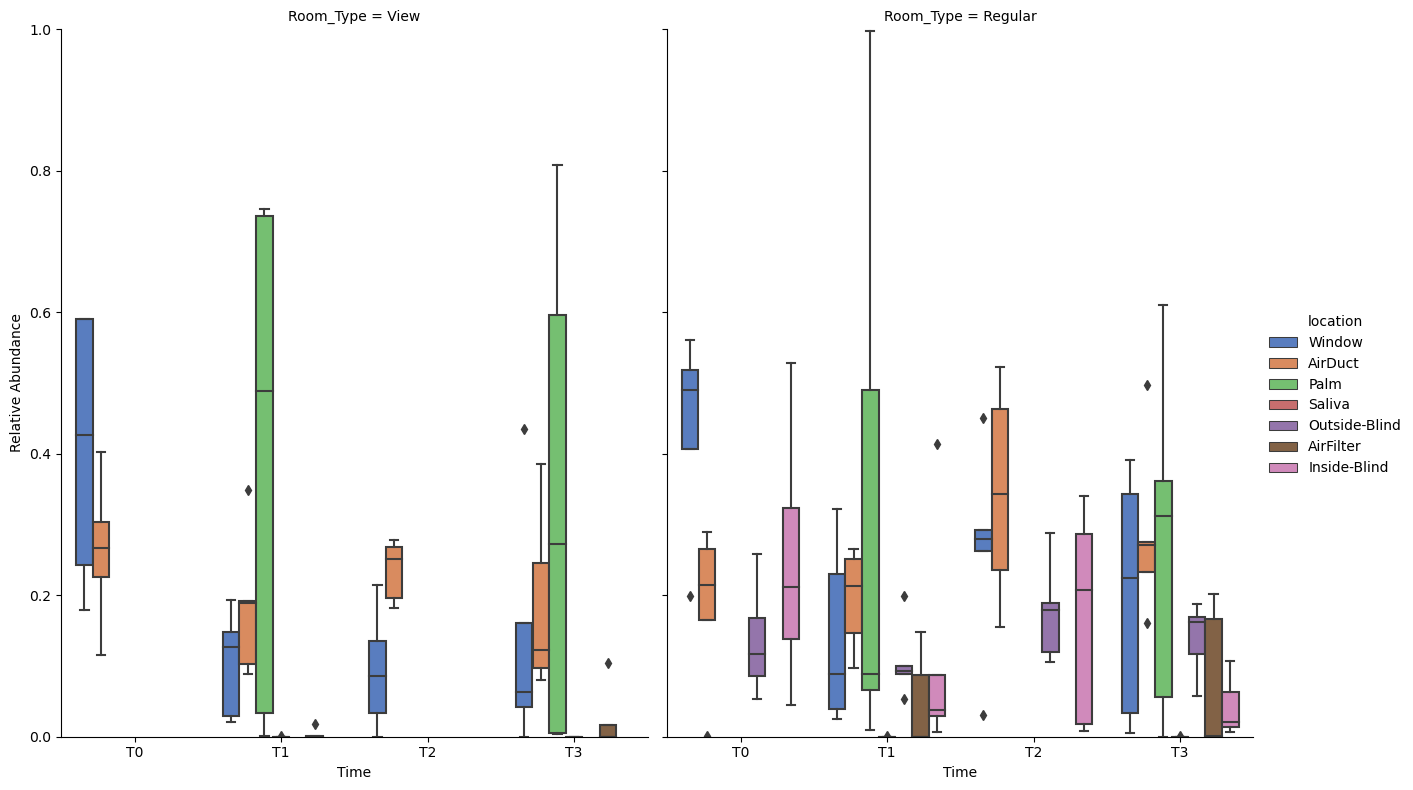

In [76]:
plt.figure(figsize= (12,10))
g = sns.catplot(x="Time", y="Abundance",
                hue="location", hue_order=['Window','AirDuct','Palm','Saliva','Outside-Blind','AirFilter','Inside-Blind'],
                col='Room_Type',order=['T0','T1','T2','T3'],
                col_wrap=2, col_order=['View','Regular'], palette='muted',
                data=Staph, kind="box", dodge=True,
                height=8, aspect=0.8);
g.set(ylabel='Relative Abundance')
plt.ylim(0,1)


* Air Sample (brown have VERY low abundance of staphylococcus relative abundance
* Saliva also did not have detectable stahylcooccus

___
### Window (Staphylcoocccus)

In [77]:
Staph_Window_Regular= subgroup(Window_Staph, "Room_Type", "Regular")
Staph_Window_View= subgroup(Window_Staph, "Room_Type", "View")
#Subgroup for each Timepoint 
Staph_WR_T0=subgroup(Staph_Window_Regular, "Time","T0")
Staph_WR_T1=subgroup(Staph_Window_Regular, "Time","T1")
Staph_WR_T2=subgroup(Staph_Window_Regular, "Time","T2")
Staph_WR_T3=subgroup(Staph_Window_Regular, "Time","T3")
Staph_WV_T0=subgroup(Staph_Window_View, "Time","T0")
Staph_WV_T1=subgroup(Staph_Window_View, "Time","T1")
Staph_WV_T2=subgroup(Staph_Window_View, "Time","T2")
Staph_WV_T3=subgroup(Staph_Window_View, "Time","T3")
Staph_WV_T3

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Phlylum,Class,Order,Family,Genus
Sample,,,,,,,,,,,
W1T3_W,1,0.160823,Window,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W3T3_W,3,0.000170,Window,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W4T3_W,4,0.434334,Window,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W5T3_W,5,0.041946,Window,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W6T3_W,6,0.063906,Window,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus


**Normality and variance test**

In [78]:
# Normality of Window Dataframe for each Timepoints
pg.normality(data=Window_Staph, dv='Abundance', group='Time')

,W,pval,normal
T0,0.828474,0.057235,True
T1,0.899980,0.218988,True
T2,0.934051,0.488901,True
T3,0.864288,0.085709,True


In [79]:
# Normality of Window Dataframe for each Timepoints
pg.normality(data=Window_Staph, dv='Abundance', group='Room_Type')

,W,pval,normal
Regular,0.934594,0.210332,True
View,0.813905,0.001833,False


In [80]:
#Leven's test for variance assumption
pg.homoscedasticity(data=Window_Staph, dv='Abundance', group='Room_Type')

,W,pval,equal_var
levene,0.260099,0.613165,True


In [81]:
#Leven's test for variance assumption
pg.homoscedasticity(data=Window_Staph, dv='Abundance', group='Time')

,W,pval,equal_var
levene,0.987015,0.410484,True


#### Effect of indoor daylight (Room Type) on relative abundnace of genus Staphylococcus on Window 

In [82]:
#At Time 0 between Two Room Type
res=ttest(Staph_WR_T0['Abundance'], Staph_WV_T0['Abundance'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.214346,6,two-sided,0.837376,"[-0.3, 0.36]",0.151566,0.531,0.053824


In [83]:
#At Time 1 between Two Room Type
res=ttest(Staph_WR_T1['Abundance'], Staph_WV_T1['Abundance'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.55725,8,two-sided,0.592601,"[-0.12, 0.19]",0.352436,0.542,0.078337


In [84]:
#At Time 2 between Two Room Type
res=ttest(Staph_WR_T2['Abundance'], Staph_WV_T2['Abundance'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.199509,8,two-sided,0.059039,"[-0.01, 0.35]",1.391092,1.685,0.489806


In [85]:
#At Time 2 between Two Room Type
res=ttest(Staph_WR_T3['Abundance'], Staph_WV_T3['Abundance'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.536246,8,two-sided,0.606373,"[-0.2, 0.31]",0.339152,0.538,0.076217


#### Effect of occupancy (Time) on relative abundnace of genus Staphylococcus on Window 

In [86]:
#Friedman Test to see the block effect of TIME
res= pg.friedman(data=Staph_Window_Regular, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.625,3,7.5,0.057558


In [87]:
# Try repeated One Way ANOVA
aov = pg.rm_anova(data=Staph_Window_View, dv="Abundance", within=["Time"], subject='Room_Number')
print(aov)

  Source  ddof1  ddof2         F     p-unc      np2       eps
0   Time      3      9  4.758945  0.029699  0.61335  0.665717


In [88]:
###Pairwise Comparison with Tukey HSD
Staph_Window_View.pairwise_tukey(dv='Abundance', between='Time').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,T0,T1,0.406,0.104,0.302,0.097,3.116,0.032,1.858
1,T0,T2,0.406,0.094,0.312,0.097,3.219,0.026,1.920
2,T0,T3,0.406,0.140,0.266,0.097,2.739,0.065,1.633
3,T1,T2,0.104,0.094,0.010,0.091,0.109,1.000,0.062
4,T1,T3,0.104,0.140,-0.037,0.091,-0.400,0.977,-0.229
5,T2,T3,0.094,0.140,-0.047,0.091,-0.509,0.956,-0.291


In [89]:
###Pairwise Comparison with Tukey HSD
Staph_Window_Regular.pairwise_tukey(dv='Abundance', between='Time').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,T0,T1,0.435,0.141,0.294,0.104,2.831,0.055,1.688
1,T0,T2,0.435,0.263,0.172,0.104,1.653,0.381,0.986
2,T0,T3,0.435,0.200,0.235,0.104,2.266,0.151,1.351
3,T1,T2,0.141,0.263,-0.122,0.098,-1.250,0.607,-0.714
4,T1,T3,0.141,0.200,-0.059,0.098,-0.599,0.931,-0.342
5,T2,T3,0.263,0.200,0.064,0.098,0.650,0.914,0.372


### Air Duct (Staphylcoocccus)

In [90]:
Staph_AirDuct_Regular= subgroup(AirDuct_Staph, "Room_Type", "Regular")
Staph_AirDuct_View= subgroup(AirDuct_Staph, "Room_Type", "View")
#Subgroup for each Timepoint 
Staph_ADR_T0=subgroup(Staph_AirDuct_Regular, "Time","T0")
Staph_ADR_T1=subgroup(Staph_AirDuct_Regular, "Time","T1")
Staph_ADR_T2=subgroup(Staph_AirDuct_Regular, "Time","T2")
Staph_ADR_T3=subgroup(Staph_AirDuct_Regular, "Time","T3")
Staph_ADV_T0=subgroup(Staph_AirDuct_View, "Time","T0")
Staph_ADV_T1=subgroup(Staph_AirDuct_View, "Time","T1")
Staph_ADV_T2=subgroup(Staph_AirDuct_View, "Time","T2")
Staph_ADV_T3=subgroup(Staph_AirDuct_View, "Time","T3")
Staph_ADV_T3

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Phlylum,Class,Order,Family,Genus
Sample,,,,,,,,,,,
W1T3_AD,1,0.245386,AirDuct,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W3T3_AD,3,0.386018,AirDuct,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W4T3_AD,4,0.080549,AirDuct,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W5T3_AD,5,0.096493,AirDuct,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W6T3_AD,6,0.123075,AirDuct,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus


**Normality and variance test**

In [91]:
# Normality of AirDuct Dataframe for each Timepoints 
#Shapiro Wilk Test
pg.normality(data=AirDuct_Staph, dv='Abundance', group='Room_Type')

,W,pval,normal
Regular,0.934488,0.169293,True
View,0.935121,0.215049,True


In [92]:
# Normality of Window Dataframe for each Timepoints
#Shapiro Wilk Test
pg.normality(data=AirDuct_Staph, dv='Abundance', group='Time')

,W,pval,normal
T0,0.952904,0.721935,True
T1,0.938029,0.497610,True
T2,0.889548,0.167601,True
T3,0.932696,0.474927,True


In [93]:
# Levene's test for variance assumption
pg.homoscedasticity(data=AirDuct_Staph, dv='Abundance', group='Room_Type')

,W,pval,equal_var
levene,0.113995,0.737499,True


In [94]:
# Levene's test for variance assumption
pg.homoscedasticity(data=AirDuct_Staph, dv='Abundance', group='Time')

,W,pval,equal_var
levene,0.379942,0.768025,True


#### Effect of indoor daylight (Room Type) on relative abundnace of genus Staphylococcus on Air Duct

In [95]:
#At Time 0 between Two Room Type
res=ttest(Staph_ADR_T0['Abundance'], Staph_ADV_T0['Abundance'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.97646,6.487178,two-sided,0.363833,"[-0.26, 0.11]",0.657086,0.672,0.136178


In [96]:
#At Time 1 between Two Room Type
res=ttest(Staph_ADR_T1['Abundance'], Staph_ADV_T1['Abundance'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.21487,6.79081,two-sided,0.836178,"[-0.12, 0.14]",0.135232,0.488,0.054622


In [97]:
#At Time 2 between Two Room Type
res=ttest(Staph_ADR_T2['Abundance'], Staph_ADV_T2['Abundance'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.529813,8,two-sided,0.164592,"[-0.06, 0.27]",0.967539,0.951,0.27128


In [98]:
#At Time 3 between Two Room Type
res=ttest(Staph_ADR_T3['Abundance'], Staph_ADV_T3['Abundance'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.253936,8,two-sided,0.245265,"[-0.08, 0.29]",0.793058,0.778,0.198088


#### Effect of occupancy (Time) on relative abundnace of genus Staphylococcus on Window 

In [99]:
# repeated One Way ANOVA
aov = pg.rm_anova(data=Staph_AirDuct_Regular, dv="Abundance", within=["Time"], subject='Room_Number')
print(aov)

  Source  ddof1  ddof2         F    p-unc      np2       eps
0   Time      3      9  2.199039  0.15778  0.42297  0.629719


In [100]:
# repeated One Way ANOVA
aov = pg.rm_anova(data=Staph_AirDuct_View, dv="Abundance", within=["Time"], subject='Room_Number')
print(aov)

  Source  ddof1  ddof2         F    p-unc      np2       eps
0   Time      3      9  0.369311  0.77712  0.10961  0.803191



### Air Sample (Staphylcoocccus)

In [101]:
Staph_AirSample_Regular= subgroup(AirSample_Staph, "Room_Type", "Regular")
Staph_AirSample_View= subgroup(AirSample_Staph, "Room_Type", "View")
#Subgroup for each Timepoint 
Staph_ASR_T1=subgroup(Staph_AirSample_Regular, "Time","T1")
Staph_ASR_T3=subgroup(Staph_AirSample_Regular, "Time","T3")
Staph_ASV_T1=subgroup(Staph_AirSample_View, "Time","T1")
Staph_ASV_T3=subgroup(Staph_AirSample_View, "Time","T3")
Staph_ASV_T3

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Phlylum,Class,Order,Family,Genus
Sample,,,,,,,,,,,
W1T3_AF,1,0.000000,AirFilter,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W3T3_AF,3,0.000184,AirFilter,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W4T3_AF,4,0.017206,AirFilter,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W5T3_AF,5,0.104609,AirFilter,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W6T3_AF,6,0.000000,AirFilter,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus


**Normality and variance test**

In [102]:
# Normality of Air sample Dataframe for each Timepoints
# Shapiro wilk test
pg.normality(data=AirSample_Staph, dv='Abundance', group='Room_Type')

,W,pval,normal
Regular,0.737387,0.002506,False
View,0.503164,0.000004,False


In [103]:
# Normality of Window Dataframe for each Timepoints
# Shapiro Wilk test
pg.normality(data=AirSample_Staph, dv='Abundance', group='Time')

,W,pval,normal
T1,0.588249,0.000040,False
T3,0.684148,0.000566,False


In [104]:
# Levene's test for variance assumption
pg.homoscedasticity(data=AirSample_Staph, dv='Abundance', group='Room_Type')

,W,pval,equal_var
levene,2.738157,0.115309,True


In [105]:
# Levene's test for variance assumption
pg.homoscedasticity(data=AirSample_Staph, dv='Abundance', group='Time')

,W,pval,equal_var
levene,0.642209,0.433364,True


#### Effect of indoor daylight (Room Type) on relative abundnace of genus Staphylococcus on Air Duct

In [106]:
#Window T1 MannWhitney U test
scipy.stats.mannwhitneyu(Staph_ASR_T1['Abundance'], Staph_ASV_T1['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=16.0, pvalue=0.5038124288130608)

In [107]:
#Window T3 MannWhitney U test
scipy.stats.mannwhitneyu(Staph_ASR_T3['Abundance'], Staph_ASV_T3['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=15.0, pvalue=0.666430033928618)

#### Effect of occupancy (Time) on relative abundnace of genus Staphylococcus on Window 

In [108]:
#Friedman Test to see the block effect of TIME
res= pg.friedman(data=Staph_AirSample_Regular, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.0,1,0.0,1.0


In [109]:
#Friedman Test to see the block effect of TIME
res= pg.friedman(data=Staph_AirSample_View, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.2,1,1.0,0.317311


### Palm (Staphylcoocccus)

In [110]:
Staph_Palm_Regular= subgroup(Palm_Staph, "Room_Type", "Regular")
Staph_Palm_View= subgroup(Palm_Staph, "Room_Type", "View")
#Subgroup for each Timepoint 
Staph_PR_T1=subgroup(Staph_Palm_Regular, "Time","T1")
Staph_PR_T3=subgroup(Staph_Palm_Regular, "Time","T3")
Staph_PV_T1=subgroup(Staph_Palm_View, "Time","T1")
Staph_PV_T3=subgroup(Staph_Palm_View, "Time","T3")
Staph_PV_T3

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Phlylum,Class,Order,Family,Genus
Sample,,,,,,,,,,,
W1T3_P,1,0.004649,Palm,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W3T3_P,3,0.003484,Palm,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W4T3_P,4,0.272655,Palm,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W5T3_P,5,0.596453,Palm,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W6T3_P,6,0.808921,Palm,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus


**Normality and variance test**

In [111]:
# Normality of Air sample Dataframe for each Timepoints
# Shapiro wilk test
pg.normality(data=Palm_Staph, dv='Abundance', group='Room_Type')

,W,pval,normal
Regular,0.862339,0.081307,True
View,0.837749,0.041466,False


In [112]:
# Normality of Air sample Dataframe for each room type
pg.normality(data=Palm_Staph, dv='Abundance', group='Time')

,W,pval,normal
T1,0.854352,0.065432,True
T3,0.891248,0.175148,True


In [113]:
# Levene's test for variance assumption
pg.homoscedasticity(data=Palm_Staph, dv='Abundance', group='Room_Type')

,W,pval,equal_var
levene,0.441552,0.514798,True


In [114]:
# Levene's test for variance assumption
pg.homoscedasticity(data=Palm_Staph, dv='Abundance', group='Time')

,W,pval,equal_var
levene,1.604265,0.221445,True


#### Effect of indoor daylight (Room Type) on relative abundnace of genus Staphylococcus on Palm

In [115]:
#At Time 1 between Two Room Type
res=ttest(Staph_PR_T1['Abundance'], Staph_PR_T1['Abundance'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.0,8,two-sided,1.0,"[-0.61, 0.61]",0.0,0.492,0.05


In [116]:
#At Time 3 between Two Room Type
res=ttest(Staph_PR_T3['Abundance'], Staph_PR_T3['Abundance'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.0,8,two-sided,1.0,"[-0.36, 0.36]",0.0,0.492,0.05


#### Effect of occupancy (Time) on relative abundnace of genus Staphylococcus on Palm

In [117]:
#Friedman Test to see the block effect of TIME
res= pg.friedman(data=Staph_Palm_View, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.04,1,0.2,0.654721


In [118]:
# Try repeated One Way ANOVA
aov = pg.rm_anova(data=Staph_Palm_Regular, dv="Abundance", within=["Time"], subject='Room_Number')
print(aov)

  Source  ddof1  ddof2         F     p-unc       np2  eps
0   Time      1      4  0.320097  0.601779  0.074095  1.0



### Saliva (Staphylcoocccus)

In [119]:
Staph_Saliva_Regular= subgroup(Saliva_Staph, "Room_Type", "Regular")
Staph_Saliva_View= subgroup(Saliva_Staph, "Room_Type", "View")
#Subgroup for each Timepoint 
Staph_SR_T1=subgroup(Staph_Saliva_Regular, "Time","T1")
Staph_SR_T3=subgroup(Staph_Saliva_Regular, "Time","T3")
Staph_SV_T1=subgroup(Staph_Saliva_View, "Time","T1")
Staph_SV_T3=subgroup(Staph_Saliva_View, "Time","T3")
Staph_SV_T3

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Phlylum,Class,Order,Family,Genus
Sample,,,,,,,,,,,
W1T3_SA,1,0.0,Saliva,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W3T3_SA,3,0.0,Saliva,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W4T3_SA,4,0.0,Saliva,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W5T3_SA,5,0.0,Saliva,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
W6T3_SA,6,0.0,Saliva,View,T3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus


**Normality and variance test**

In [120]:
# Normality of Air sample Dataframe for each Timepoints
# Shapiro wilk test
pg.normality(data=Saliva_Staph, dv='Abundance', group='Room_Type')

,W,pval,normal
Regular,0.515407,5.515257e-06,False
View,0.365721,1.003693e-07,False


In [121]:
pg.normality(data=Saliva_Staph, dv='Abundance', group='Time')

,W,pval,normal
T1,0.525124,7.175663e-06,False
T3,0.365721,1.003693e-07,False


In [122]:
# Levene's test for variance assumption
pg.homoscedasticity(data=Saliva_Staph, dv='Abundance', group='Room_Type')

,W,pval,equal_var
levene,0.21752,0.646531,True


In [123]:
pg.homoscedasticity(data=Saliva_Staph, dv='Abundance', group='Time')

,W,pval,equal_var
levene,0.477908,0.498192,True


#### Effect of indoor daylight (Room Type) on relative abundnace of genus Staphylococcus on Saliva

In [124]:
#Saliva at T1: MannWhitney U test bewteen Room Type
scipy.stats.mannwhitneyu(Staph_SR_T1['Abundance'], Staph_SV_T1['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=12.0, pvalue=1.0)

In [125]:
#Saliva at T3: MannWhitney U test bewteen Room Type
scipy.stats.mannwhitneyu(Staph_SR_T3['Abundance'], Staph_SV_T3['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=15.0, pvalue=0.4237107971667934)

#### Effect of occupancy (Time) on relative abundnace of genus Staphylococcus on Saliva

In [126]:
#Friedman Test to see the block effect of TIME
res= pg.friedman(data=Staph_Saliva_Regular, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.2,1,1.0,0.317311


In [127]:
#Friedman Test to see the block effect of TIME
res= pg.friedman(data=Staph_Saliva_View, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.2,1,1.0,0.317311


___
## Statistical analysis: Pseudomonas

### Initial Data vaisualization

(0.0, 1.0)

<Figure size 1000x800 with 0 Axes>

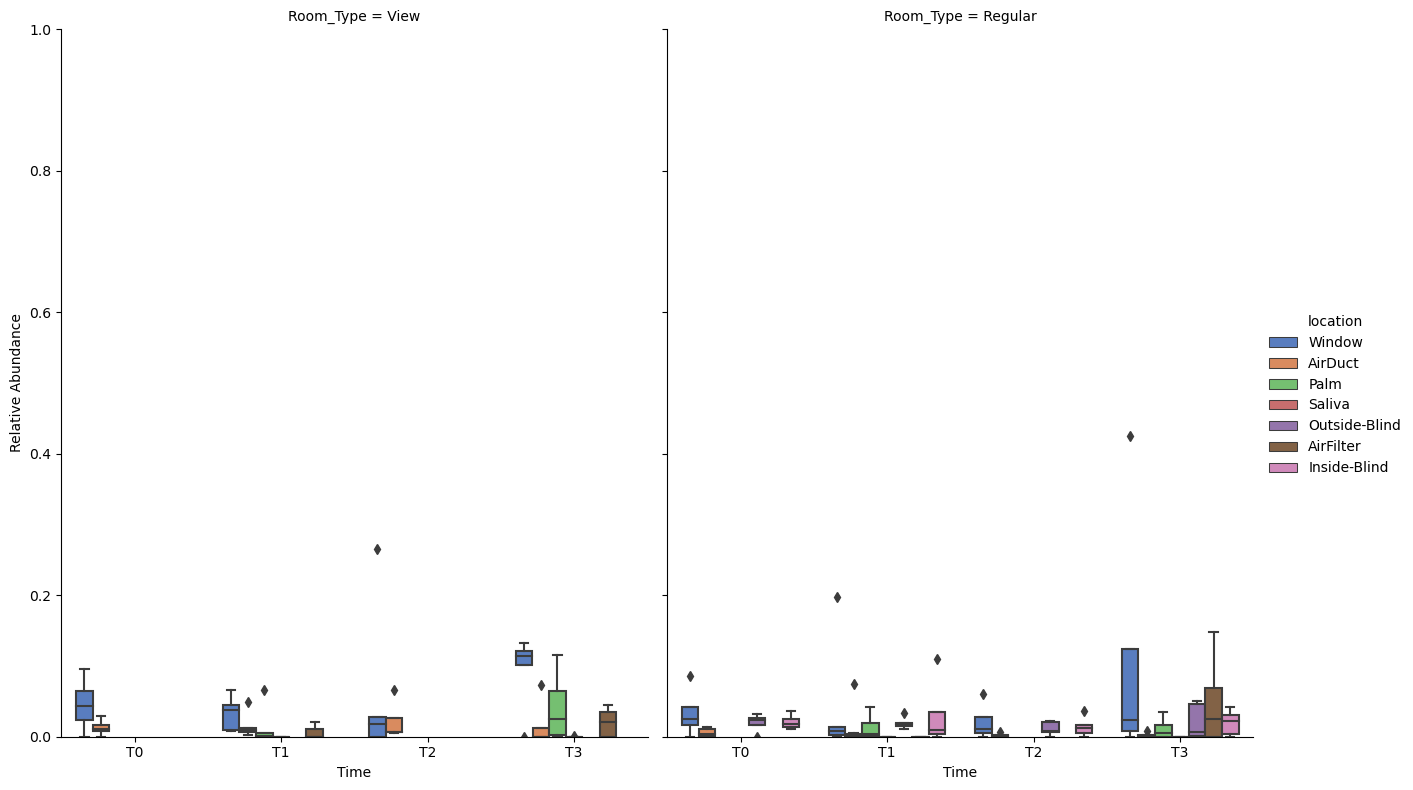

In [128]:
plt.figure(figsize= (10,8))
g = sns.catplot(x="Time", y="Abundance",
                hue="location", hue_order=['Window','AirDuct','Palm','Saliva','Outside-Blind','AirFilter','Inside-Blind'],
                col='Room_Type',order=['T0','T1','T2','T3'],
                col_wrap=2, col_order=['View','Regular'], palette='muted',
                data=Pseudo, kind="box", dodge=True,
                height=8, aspect=.8);
g.set(ylabel='Relative Abundance')
plt.ylim(0,1)

* From the intiial data visualization, it can be shown that genus Pseudmonas are very low in abundance
* Air Sample and Saliva barely have any detectable Pseudomonas, thus will not be included in the analysis
___
### Window (Pseudomonas)

In [129]:
# Subgroup based on the room type
Pseudo_Window_Regular= subgroup(Window_Pseudo, "Room_Type", "Regular")
Pseudo_Window_View= subgroup(Window_Pseudo, "Room_Type", "View")
#Subgroup for each Timepoint 
Pseudo_WR_T0=subgroup(Pseudo_Window_Regular, "Time","T0")
Pseudo_WR_T1=subgroup(Pseudo_Window_Regular, "Time","T1")
Pseudo_WR_T2=subgroup(Pseudo_Window_Regular, "Time","T2")
Pseudo_WR_T3=subgroup(Pseudo_Window_Regular, "Time","T3")
Pseudo_WV_T0=subgroup(Pseudo_Window_View, "Time","T0")
Pseudo_WV_T1=subgroup(Pseudo_Window_View, "Time","T1")
Pseudo_WV_T2=subgroup(Pseudo_Window_View, "Time","T2")
Pseudo_WV_T3=subgroup(Pseudo_Window_View, "Time","T3")
Pseudo_WV_T3

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Genus
Sample,,,,,,,
W1T3_W,1,0.121154,Window,View,T3,Bacteria,Pseudomonas
W3T3_W,3,0.132154,Window,View,T3,Bacteria,Pseudomonas
W4T3_W,4,0.000000,Window,View,T3,Bacteria,Pseudomonas
W5T3_W,5,0.101342,Window,View,T3,Bacteria,Pseudomonas
W6T3_W,6,0.114535,Window,View,T3,Bacteria,Pseudomonas


**Normality and variance test**

In [130]:
# Normality of Window Dataframe for each Timepoints
pg.normality(data=Window_Pseudo, dv='Abundance', group='Time')

,W,pval,normal
T0,0.901633,0.298874,True
T1,0.661569,0.000302,False
T2,0.559093,0.000018,False
T3,0.742120,0.002861,False


In [131]:
# Normality of Window Dataframe for each Timepoints
pg.normality(data=Window_Pseudo, dv='Abundance', group='Room_Type')

,W,pval,normal
Regular,0.577780,0.000003,False
View,0.818627,0.002159,False


In [132]:
# Levene's test for variance assumption
pg.homoscedasticity(data=Window_Pseudo, dv='Abundance', group='Room_Type')

,W,pval,equal_var
levene,0.015524,0.901537,True


In [133]:
# Levene's test for variance assumption
pg.homoscedasticity(data=Window_Pseudo, dv='Abundance', group='Time')

,W,pval,equal_var
levene,1.07335,0.373355,True


#### Staitiscal test between room type at each time
* Only T0(baseline) is normally distributed. All other dataset failed the normality assumption

In [134]:
#At Time 0 between Two Room Type
res=ttest(Pseudo_WR_T0['Abundance'], Pseudo_WV_T0['Abundance'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.413736,6,two-sided,0.693449,"[-0.08, 0.06]",0.292555,0.551,0.064318


In [135]:
#Window T0 MannWhitney U test
scipy.stats.mannwhitneyu(Pseudo_WR_T0['Abundance'], Pseudo_WV_T0['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=5.5, pvalue=0.5613632102341237)

In [136]:
#Window T1 MannWhitney U test
scipy.stats.mannwhitneyu(Pseudo_WR_T1['Abundance'], Pseudo_WV_T1['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=8.0, pvalue=0.42063492063492064)

In [137]:
#Window T2 MannWhitney U test
scipy.stats.mannwhitneyu(Pseudo_WR_T2['Abundance'], Pseudo_WV_T2['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=12.0, pvalue=1.0)

In [138]:
#Window T3 MannWhitney U test
scipy.stats.mannwhitneyu(Pseudo_WR_T3['Abundance'], Pseudo_WV_T3['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=11.5, pvalue=0.9165626446795413)

#### Statistical test between time in each room (effect of occupancy)

In [139]:
#Regular room: Friedman Test to see the block effect of TIME
res= pg.friedman(data=Pseudo_Window_Regular, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.044872,3,0.538462,0.910364


In [140]:
#EC Window Room: Friedman Test to see the block effect of TIME
res= pg.friedman(data=Pseudo_Window_View, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.121795,3,1.461538,0.691175



### Air Duct (Pseudomonas)

In [141]:
Pseudo_AirDuct_Regular= subgroup(AirDuct_Pseudo, "Room_Type", "Regular")
Pseudo_AirDuct_View= subgroup(AirDuct_Pseudo, "Room_Type", "View")
#Subgroup for each Timepoint 
Pseudo_ADR_T0=subgroup(Pseudo_AirDuct_Regular, "Time","T0")
Pseudo_ADR_T1=subgroup(Pseudo_AirDuct_Regular, "Time","T1")
Pseudo_ADR_T2=subgroup(Pseudo_AirDuct_Regular, "Time","T2")
Pseudo_ADR_T3=subgroup(Pseudo_AirDuct_Regular, "Time","T3")
Pseudo_ADV_T0=subgroup(Pseudo_AirDuct_View, "Time","T0")
Pseudo_ADV_T1=subgroup(Pseudo_AirDuct_View, "Time","T1")
Pseudo_ADV_T2=subgroup(Pseudo_AirDuct_View, "Time","T2")
Pseudo_ADV_T3=subgroup(Pseudo_AirDuct_View, "Time","T3")
Pseudo_ADV_T3

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Genus
Sample,,,,,,,
W1T3_AD,1,0.012920,AirDuct,View,T3,Bacteria,Pseudomonas
W3T3_AD,3,0.000000,AirDuct,View,T3,Bacteria,Pseudomonas
W4T3_AD,4,0.072883,AirDuct,View,T3,Bacteria,Pseudomonas
W5T3_AD,5,0.000000,AirDuct,View,T3,Bacteria,Pseudomonas
W6T3_AD,6,0.000000,AirDuct,View,T3,Bacteria,Pseudomonas


**Normlaity and variance test**

In [142]:
# Normality of AirDuct Dataframe for each Timepoints
pg.normality(data=AirDuct_Pseudo, dv='Abundance', group='Room_Type')

,W,pval,normal
Regular,0.412019,3.456167e-08,False
View,0.743973,1.952477e-04,False


In [143]:
# Normality of AirDuct Dataframe for each Timepoints
pg.normality(data=AirDuct_Pseudo, dv='Abundance', group='Time')

,W,pval,normal
T0,0.856205,0.087168,True
T1,0.651035,0.000111,False
T2,0.615812,0.000085,False
T3,0.503507,0.000004,False


In [144]:
# Levene's test for variance assumption
pg.homoscedasticity(data=AirDuct_Pseudo, dv='Abundance', group='Time')

,W,pval,equal_var
levene,0.178423,0.910329,True


In [145]:
# Levene's test for variance assumption
pg.homoscedasticity(data=AirDuct_Pseudo, dv='Abundance', group='Room_Type')

,W,pval,equal_var
levene,2.06148,0.159245,True


#### Statistical test between room type to see the effect of indoor daylight at each time

In [146]:
# T0 MannWhitney U test
scipy.stats.mannwhitneyu(Pseudo_ADR_T0['Abundance'], Pseudo_ADV_T0['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=6.5, pvalue=0.4605581692270928)

In [147]:
# T1 MannWhitney U test
scipy.stats.mannwhitneyu(Pseudo_ADR_T1['Abundance'], Pseudo_ADV_T1['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=7.0, pvalue=0.16699411792618535)

In [148]:
# T1 MannWhitney U test
scipy.stats.mannwhitneyu(Pseudo_ADR_T2['Abundance'], Pseudo_ADV_T2['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=1.0, pvalue=0.021176657854316622)

In [149]:
# T1 MannWhitney U test
scipy.stats.mannwhitneyu(Pseudo_ADR_T3['Abundance'], Pseudo_ADV_T3['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=12.0, pvalue=1.0)

#### Statistical test between Time to see the effect of occupancy in each type of room

In [150]:
#Friedman Test to see the block effect of TIME
res= pg.friedman(data=Pseudo_AirDuct_Regular, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.492857,3,5.914286,0.115856


In [151]:
#Friedman Test to see the block effect of TIME
res= pg.friedman(data=Pseudo_AirDuct_View, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.057692,3,0.692308,0.875012


### Air Sample (Pseudomoans)

In [152]:
Pseudo_AirSample_Regular= subgroup(AirSample_Pseudo, "Room_Type", "Regular")
Pseudo_AirSample_View= subgroup(AirSample_Pseudo, "Room_Type", "View")
#Subgroup for each Timepoint 
Pseudo_ASR_T1=subgroup(Pseudo_AirSample_Regular, "Time","T1")
Pseudo_ASR_T3=subgroup(Pseudo_AirSample_Regular, "Time","T3")
Pseudo_ASV_T1=subgroup(Pseudo_AirSample_View, "Time","T1")
Pseudo_ASV_T3=subgroup(Pseudo_AirSample_View, "Time","T3")
Pseudo_ASV_T3

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Genus
Sample,,,,,,,
W1T3_AF,1,0.035508,AirFilter,View,T3,Bacteria,Pseudomonas
W3T3_AF,3,0.020783,AirFilter,View,T3,Bacteria,Pseudomonas
W4T3_AF,4,0.000000,AirFilter,View,T3,Bacteria,Pseudomonas
W5T3_AF,5,0.044918,AirFilter,View,T3,Bacteria,Pseudomonas
W6T3_AF,6,0.000000,AirFilter,View,T3,Bacteria,Pseudomonas


**Normality and variance test**

In [153]:
# Normality of AirSample Dataframe for each Timepoints
pg.normality(data=AirSample_Pseudo, dv='Abundance', group='Room_Type')

,W,pval,normal
Regular,0.593983,0.000047,False
View,0.805878,0.017089,False


In [154]:
# Normality of AirSample Dataframe for each Time
pg.normality(data=AirSample_Pseudo, dv='Abundance', group='Time')

,W,pval,normal
T1,0.531733,0.000009,False
T3,0.770221,0.006293,False


In [155]:
# Levene's test for variance assumption
pg.homoscedasticity(data=AirSample_Pseudo, dv='Abundance', group='Time')

,W,pval,equal_var
levene,5.501729,0.030656,False


In [156]:
# Levene's test for variance assumption
pg.homoscedasticity(data=AirSample_Pseudo, dv='Abundance', group='Room_Type')

,W,pval,equal_var
levene,0.471284,0.501146,True


#### Statistical test between room type to see the effect of indoor daylight at each time

In [157]:
#T1 MannWhitney U test
scipy.stats.mannwhitneyu(Staph_ASR_T1['Abundance'], Staph_ASV_T1['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=16.0, pvalue=0.5038124288130608)

In [158]:
#T3 MannWhitney U test
scipy.stats.mannwhitneyu(Staph_ASR_T3['Abundance'], Staph_ASV_T3['Abundance'],alternative='two-sided')

MannwhitneyuResult(statistic=15.0, pvalue=0.666430033928618)

#### Statistical test between Time to see the effect of occupancy

In [159]:
#Friedman Test to see the block effect of TIME
res= pg.friedman(data=Pseudo_AirSample_Regular, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.6,1,3.0,0.083265


In [160]:
#Friedman Test to see the block effect of TIME
res= pg.friedman(data=Pseudo_AirSample_View, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.2,1,1.0,0.317311


### Palm (Pseudomoans)

In [161]:
Pseudo_Palm_Regular= subgroup(Palm_Pseudo, "Room_Type", "Regular")
Pseudo_Palm_View= subgroup(Palm_Pseudo, "Room_Type", "View")
#Subgroup for each Timepoint 
Pseudo_PR_T1=subgroup(Pseudo_Palm_Regular, "Time","T1")
Pseudo_PR_T3=subgroup(Pseudo_Palm_Regular, "Time","T3")
Pseudo_PV_T1=subgroup(Pseudo_Palm_View, "Time","T1")
Pseudo_PV_T3=subgroup(Pseudo_Palm_View, "Time","T3")
Pseudo_PV_T3

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Genus
Sample,,,,,,,
W1T3_P,1,0.064143,Palm,View,T3,Bacteria,Pseudomonas
W3T3_P,3,0.000345,Palm,View,T3,Bacteria,Pseudomonas
W4T3_P,4,0.025437,Palm,View,T3,Bacteria,Pseudomonas
W5T3_P,5,0.115670,Palm,View,T3,Bacteria,Pseudomonas
W6T3_P,6,0.002280,Palm,View,T3,Bacteria,Pseudomonas


**Normalty and variance test**

In [162]:
# Normality of Window Dataframe for each Timepoints
pg.normality(data=Palm_Pseudo, dv='Abundance', group='Time')

,W,pval,normal
T1,0.694031,0.000746,False
T3,0.760890,0.004843,False


In [163]:
# Normality of Window Dataframe for each type of room
pg.normality(data=Palm_Pseudo, dv='Abundance', group='Room_Type')

,W,pval,normal
Regular,0.806669,0.017471,False
View,0.750875,0.003657,False


#### Statistical test between room type to see the effect of indoo daylight at each time

In [164]:
#At Time 1 between Two Room Type
res=ttest(Staph_PR_T1['Abundance'], Staph_PV_T1['Abundance'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.282832,8,two-sided,0.784486,"[-0.64, 0.5]",0.178879,0.505,0.057227


In [165]:
#At Time 1 between Two Room Type
res=ttest(Staph_PR_T3['Abundance'], Staph_PV_T3['Abundance'],paired = False)
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.35595,8,two-sided,0.731082,"[-0.52, 0.38]",0.225123,0.512,0.061471


#### Statistical test between time to see the effect of occupancy

In [166]:
#Regular Room Friedman Test to see the block effect of TIME 
res= pg.friedman(data=Pseudo_Palm_Regular, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.04,1,0.2,0.654721


In [167]:
#EC window room: Friedman Test to see the block effect of TIME
res= pg.friedman(data=Pseudo_Palm_View, dv="Abundance", within="Time", subject="Room_Number")
res

,Source,W,ddof1,Q,p-unc
Friedman,Time,0.36,1,1.8,0.179712


### Saliva (Pseudomoans)

In [168]:
Saliva_Pseudo

,Room_Number,Abundance,location,Room_Type,Time,Kingdom,Genus
Sample,,,,,,,
R1T1_SA,1,0.000000,Saliva,Regular,T1,Bacteria,Pseudomonas
R1T3_SA,1,0.000000,Saliva,Regular,T3,Bacteria,Pseudomonas
R2T1_SA,2,0.000000,Saliva,Regular,T1,Bacteria,Pseudomonas
R2T3_SA,2,0.000000,Saliva,Regular,T3,Bacteria,Pseudomonas
R3T1_SA,3,0.000000,Saliva,Regular,T1,Bacteria,Pseudomonas
R3T3_SA,3,0.000000,Saliva,Regular,T3,Bacteria,Pseudomonas
R5T1_SA,5,0.000000,Saliva,Regular,T1,Bacteria,Pseudomonas
R5T3_SA,5,0.000000,Saliva,Regular,T3,Bacteria,Pseudomonas
R6T1_SA,6,0.000000,Saliva,Regular,T1,Bacteria,Pseudomonas


* Pseudo is NOT detected in any of the patient saliva, so no further analysis is needed